In [1]:
import copy
import math
from typing import Mapping

import numpy as np
import torch
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torchvision.datasets import CelebA
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import warnings

# SETUP

### Plotting

In [2]:
def show_with_attr(attr, has_attr, columns=5):
    train_idx = np.where(datasets[train_label].attr[:, attr] == has_attr)[0]
    valid_idx = np.where(datasets[valid_label].attr[:, attr] == has_attr)[0]
    attr_name = datasets[train_label].attr_names[attr]
    print(f"{attr_name}: {train_idx.shape[0]}, {valid_idx.shape[0]}")
    fig, ax = plt.subplots(1, columns, figsize=(20, 10))
    for i in range(columns):
        rnd = np.random.randint(0, train_idx.shape[0] - columns)
        rnd_idx = train_idx[rnd + i]
        ax[i].imshow(datasets[train_label][rnd_idx][0].permute(1, 2, 0))
        ax[i].set_title(f"{attr_name}: {rnd_idx}")
        ax[i].axis("off")


def show_identity_images(id, columns=5):
    valid_set = datasets[valid_label]
    idxs = np.where(valid_set.identity == id)[0]
    if len(idxs) == 0:
        print("No images with that identity")
        return
    rows = math.ceil(len(idxs) / columns)
    fig, ax = plt.subplots(rows, columns, figsize=(10, 10))
    for i in range(columns * rows):
        if i < len(idxs):
            ax[i // columns, i % columns].imshow(valid_set[idxs[i]][0].permute(1, 2, 0))
            ax[i // columns, i % columns].set_title(f"Index: {idxs[i]}")
        ax[i // columns, i % columns].axis('off')

    plt.tight_layout()
    plt.show()


def plot_triplets(img_label_pairs):
    fig, ax = plt.subplots(len(img_label_pairs), 3, figsize=(10, 10))
    if len(img_label_pairs) == 1:
        ax = np.array([ax])
    titles = ["Anchor", "Positive", "Negative"]
    for i, (img, labels) in enumerate(img_label_pairs):
        for j in range(3):
            ax[i, j].imshow(img[j].permute(1, 2, 0))
            if labels:
                ax[i, j].set_title(f"{titles[j]}\nIdentity: {labels[j]}")
            ax[i, j].axis('off')

    # plt.subplots_adjust(hspace=1, wspace=-0.5)
    plt.tight_layout()
    plt.show()


def visualize_results(train_loss_history, val_loss_history, val_acc_history):
    assert len(train_loss_history) == len(val_loss_history) == len(val_acc_history), "Unequal history lengths"
    x_axis = []
    for i in range(len(train_loss_history)):
        x_axis.append(i+1)

    x_label = "Epoch"
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].plot(x_axis, train_loss_history, label="Train Loss")
    ax[0].set_title("Train Loss")
    ax[0].set_xlabel(x_label)
    
    ax[1].plot(x_axis, val_loss_history, label="Val Loss")
    ax[1].set_title("Val Loss")
    ax[1].set_xlabel(x_label)
    
    ax[2].plot(x_axis, val_acc_history)
    ax[2].set_title("Accuracy")
    ax[2].set_xlabel(x_label)
    plt.show()


def show_predictions(triplet_net, triplet_data_loader, num_correct=2, num_incorrect=2):
    correct_imgs = []
    incorrect_imgs = []
    cur_correct = 0
    cur_incorrect = 0
    triplet_net.eval()
    with torch.no_grad():
        for i, triplet_batch in enumerate(triplet_data_loader):
            anchor, positive, negative = triplet_batch[0]
            anchors, positives, negatives = triplet_net(anchor.cuda(), positive.cuda(), negative.cuda())
            anchors, positives, negatives = anchors.cpu(), positives.cpu(), negatives.cpu()
            for j in range(len(anchors)):
                anchor_pos_dist = np.linalg.norm(anchors[j] - positives[j])
                anchor_neg_dist = np.linalg.norm(anchors[j] - negatives[j])
                if anchor_pos_dist < anchor_neg_dist:
                    if cur_correct < num_correct:
                        correct_imgs.append(((anchor[j], positive[j], negative[j]),
                                             [triplet_batch[1][0][j], triplet_batch[1][1][j], triplet_batch[1][2][j]]))
                        cur_correct += 1
                else:
                    if cur_incorrect < num_incorrect:
                        incorrect_imgs.append(((anchor[j], positive[j], negative[j]),
                                               [triplet_batch[1][0][j], triplet_batch[1][1][j],
                                                triplet_batch[1][2][j]]))
                        cur_incorrect += 1
                if cur_correct == num_correct and cur_incorrect == num_incorrect:
                    break
            if cur_correct == num_correct and cur_incorrect == num_incorrect:
                break
        print("Correct predictions:")
        plot_triplets(correct_imgs)
        print("Incorrect predictions:")
        plot_triplets(incorrect_imgs)


def merge_trainstats_histories(old_history, add_to_history):
    for s in range(len(old_history)):
        old_history[s].extend(add_to_history[s])
    return old_history


def add_valstats_history(history, loss, acc):
    if len(history[0]) > 0:
        history[1][-1] = loss
        history[2][-1] = acc
    else:
        history[0], history[1], history[2], history[3] = [None], [loss], [acc], [0]

### Triplet Sampler and Dataset

In [3]:
# A triplet batch is (Labels, Images) x (Anchor, Positive, Negative) x Batch Size x Channels x Height x Width
# = 2 x 3 x 16 x 3 x 218 x 178

# Custom sampler class that generates batches with of triplets of images
class TripletSampler(data.sampler.Sampler):
    def __init__(self, cleaned_identities: np.ndarray):
        super().__init__()
        self.cleaned_identities = cleaned_identities  # Same size as original dataset. Invalid entries have identity '0'.
        self.identity_array = self.create_identity_array(cleaned_identities)

    def __getitem__(self, anchor_idx: int) -> tuple[int, int, int] | None:
        # Get a random anchor image and its identity
        anchor_identity = self.cleaned_identities[anchor_idx]
        if anchor_identity == 0: return None  # Found invalid entry. Skip this triplet. 
        # Get all indexes with the same identity
        anchor_image_indices = self.identity_array[anchor_identity]
        # remove the anchor image from the list
        positive_identity_indices = anchor_image_indices[anchor_image_indices != anchor_idx]
        if len(positive_identity_indices) == 0: return None  # Anchor identity only had 1 image. Skip this triplet. 
        # Get a random positive image
        positive_idx = positive_identity_indices[np.random.randint(len(positive_identity_indices))]
        # Choose random image as negative and confirm that it differs from anchor 
        negative_idx = np.random.randint(len(self.cleaned_identities))
        while self.cleaned_identities[negative_idx] == anchor_identity  or self.cleaned_identities[negative_idx] == 0:
            negative_idx = np.random.randint(len(self.cleaned_identities))  # Try again

        return anchor_idx, positive_idx, negative_idx

    def __iter__(self):
        for i in range(len(self.cleaned_identities)):
            next_triple = self[i]
            if next_triple is None: continue
            yield next_triple

    def __len__(self):
        return len(self.cleaned_identities)

    @staticmethod
    def create_identity_array(identities: np.ndarray) -> np.ndarray:
        # Create array where identity is the index to an array of all indexes of images of that identity
        identity_array = np.empty(max(identities) + 1, dtype=object)
        for i, id in enumerate(identities):
            if id == 0: continue
            if identity_array[id] is None:
                identity_array[id] = np.array([i])
            else:
                identity_array[id] = np.append(identity_array[id], i)

        return identity_array

class TripletDataset(torch.utils.data.Dataset):
    def __init__(self, dataset: CelebA, cleaned_identities: np.ndarray):
        self.dataset = dataset
        self.cleaned_identities = cleaned_identities

    def __getitem__(self, triplet_idx: tuple[int, int, int]) -> tuple[
        tuple[torch.Tensor, torch.Tensor, torch.Tensor], tuple[torch.Tensor, torch.Tensor, torch.Tensor]]:
        anchor_idx, positive_idx, negative_idx = triplet_idx
        a_img, _ = self.dataset[anchor_idx]
        p_img, _ = self.dataset[positive_idx]
        n_img, _ = self.dataset[negative_idx]
        a_label = self.cleaned_identities[anchor_idx]
        p_label = self.cleaned_identities[positive_idx]
        n_label = self.cleaned_identities[negative_idx]
        assert a_label == p_label and a_label != n_label, f"Triplet label prerequisites violated: Anchor ({a_label}), Positive ({p_label}), Negative ({n_label})"
        return (a_img, p_img, n_img), (a_label, p_label, n_label)

    def __len__(self) -> int:
        return len(self.dataset)

In [4]:
data_dir = "data/"
bs = 128
target_type = 'identity'
train_label, valid_label, test_label = "train", "valid", "test"
dataset_labels = [train_label, valid_label, test_label]
dataset_transforms = {
    train_label: transforms.Compose(
        [transforms.ToTensor()]),
    valid_label: transforms.Compose(
        [transforms.ToTensor()]),
    test_label: transforms.Compose(
        [transforms.ToTensor()])
}
datasets: Mapping[str, CelebA] = {label: CelebA(root=data_dir, split=label, target_type=target_type, download=True,
                                                transform=dataset_transforms[label]) for label in dataset_labels}
dataset_sizes: Mapping[str, int] = {label: len(datasets[label]) for label in dataset_labels}
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### <a href="https://github.com/C3Imaging/Deep-Learning-Techniques/tree/clean-celebA">Data cleaning</a>

In [73]:
celeba_identity_clean = np.zeros(sum(dataset_sizes.values()), dtype=int)
with open(data_dir + "celeba/clean_CelebA_v1_img_list.txt", "r") as f:
    for line in f:
        identity, idx = line.split("/")
        celeba_identity_clean[int(idx[:-5]) - 1] = int(identity)

In [74]:
train_size = dataset_sizes[train_label]
different = (1 - sum(
    datasets[train_label].identity.numpy().squeeze() == celeba_identity_clean[:train_size]) / train_size) * 100
deleted = (sum(celeba_identity_clean == 0) / train_size) * 100
print(f"{round(deleted, 3)}% identities of deleted, {round(deleted - different, 3)}% identities of changed")

3.147% identities of deleted, 0.496% identities of changed


In [75]:
with open(data_dir + "celeba/deleted_CelebA_v1_img_list.txt", "r") as f:
    for line in f:
        identity, filename = line.split("/")
        idx = int(filename[:-5]) - 1
        if (idx < dataset_sizes[train_label] and datasets[train_label].identity[idx] != int(identity)) or \
                celeba_identity_clean[idx] != 0:
            print("Error")
            break
    else:
        print("Verified changed and deleted identities")

Verified changed and deleted identities


### Attribute filtering

In [76]:
def filter_attr(attr_id: int):
    all_attr = np.concatenate((datasets[train_label].attr, datasets[valid_label].attr, datasets[test_label].attr))
    has_attr = all_attr[:, attr_id] == 1
    val_start = dataset_sizes[train_label]
    test_start = val_start + dataset_sizes[valid_label]

    # count how many are set to 0 from each set, that wasn't already 0 in celeba_identity_clean
    train_removed = sum(has_attr[:val_start] & (celeba_identity_clean[:val_start] != 0))
    valid_removed = sum(has_attr[val_start:test_start] & (celeba_identity_clean[val_start:test_start] != 0))
    test_removed = sum(has_attr[test_start:] & (celeba_identity_clean[test_start:] != 0))
    celeba_identity_clean[has_attr] = 0

    print(f"Removing all with attribute '{datasets[train_label].attr_names[attr_id]}'")
    print(f" Removed from train: {train_removed} ({sum(has_attr[:val_start])})")
    print(f" Removed from valid: {valid_removed} ({sum(has_attr[val_start:test_start])})")
    print(f" Removed from test: {test_removed} ({sum(has_attr[test_start:])})")
    print(f" Total removed: {train_removed + valid_removed + test_removed} ({sum(has_attr)})")
    print()


filter_attr(10)
# filter_attr(15)
filter_attr(35)

Removing all with attribute 'Blurry'
 Removed from train: 7934 (8362)
 Removed from valid: 904 (940)
 Removed from test: 981 (1010)
 Total removed: 9819 (10312)

Removing all with attribute 'Wearing_Hat'
 Removed from train: 7358 (8039)
 Removed from valid: 859 (940)
 Removed from test: 770 (839)
 Total removed: 8987 (9818)



### Post-cleaning summary

In [77]:
train_size = dataset_sizes[train_label]
valid_size = dataset_sizes[valid_label]
test_size = dataset_sizes[test_label]

train_left = sum(celeba_identity_clean[:train_size] != 0)
valid_left = sum(celeba_identity_clean[train_size:train_size + valid_size] != 0)
test_left = sum(celeba_identity_clean[train_size + valid_size:] != 0)
print(f"Train samples left: {train_left}, from {train_size} ({train_left - train_size})")
print(f"Valid samples left: {valid_left}, from {valid_size} ({valid_left - valid_size})")
print(f"Test samples left: {test_left}, from {test_size} ({test_left - test_size})")

Train samples left: 143164, from 162770 (-19606)
Valid samples left: 17653, from 19867 (-2214)
Test samples left: 17854, from 19962 (-2108)


In [78]:
cleaned_identities_splits = {"train": celeba_identity_clean[:train_size],
                             "valid": celeba_identity_clean[train_size:train_size + valid_size],
                             "test": celeba_identity_clean[train_size + valid_size:]}
dataloaders: Mapping[str, data.DataLoader] = {
    label: data.DataLoader(TripletDataset(datasets[label], cleaned_identities_splits[label]), batch_size=bs, shuffle=False, num_workers=0,
                           sampler=TripletSampler(cleaned_identities_splits[label])) for label in dataset_labels}

# Model & Fit

In [ ]:
class TripletNet(nn.Module):
    def __init__(self):
        super(TripletNet, self).__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.resnet.fc = nn.Identity()  # Override last layer of resnet to replace with our own fc layers
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
        )

        # Initialize the fc layers with xavier
        for layer in self.fc:
            if type(layer) == nn.Linear:
                nn.init.xavier_uniform_(layer.weight)

    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor):
        anchor = self.resnet(anchor)
        anchor = self.fc(anchor)
        positive = self.resnet(positive)
        positive = self.fc(positive)
        negative = self.resnet(negative)
        negative = self.fc(negative)
        return anchor, positive, negative

class WeightContainer:
    def __init__(self, model_dict, optimizer_dict, scheduler_dict):
        self.model_dict = model_dict
        self.optimizer_dict = optimizer_dict
        self.scheduler_dict = scheduler_dict

def train_triplet_net(triplet_net: TripletNet,
                      criterion,
                      optimizer,
                      lr_scheduler,
                      epochs,
                      num_batches=None,
                      num_val_batches=None,
                      freeze=False,
                      verbose=True) -> tuple[WeightContainer, tuple[list, list, list]]:
    train_loss_history = []
    val_loss_history = []
    val_acc_history = []

    if num_batches is None: num_batches = len(dataloaders[train_label])

    print_stats = lambda: print(f"Epoch: {epoch + 1}, Batch: {batch_i + 1}",
                                f"Train Loss: {round(running_loss, 3)}",
                                f"Val Loss: {round(val_loss, 3)}",
                                f"Val Accuracy: {round(val_acc, 3)}        ",
                                end='\n' if verbose else '\r')

    for param in triplet_net.resnet.parameters():
        param.requires_grad = not freeze
    triplet_net.fc.requires_grad = True

    train_step = make_train_step(triplet_net, criterion, optimizer)
    
    # Remember best model setting
    best_acc = 0.0
    best_model_weights = copy.deepcopy(triplet_net.state_dict())
    best_optimizer_weights = copy.deepcopy(optimizer.state_dict())
    best_scheduler_weights = copy.deepcopy(lr_scheduler.state_dict())

    early_stopping_counter = 0
    try:
        for epoch in range(epochs):
            running_loss = 0.0
            previous_best_accuracy = best_acc
            for batch_i, triplet_batch in enumerate(dataloaders[train_label]):
                running_loss += train_step(triplet_batch)

                if batch_i == num_batches - 1:  # Skip (early) to next epoch
                    train_loss_history.append(running_loss / num_batches)

                    print("Validating...      ", end='\r')
                    val_loss, val_acc = val_triplet_net(triplet_net, criterion, batches=num_val_batches)
                    print("", end='\r')
                    val_loss_history.append(val_loss)
                    val_acc_history.append(val_acc)
                    print_stats()
                    running_loss = 0.0

                    if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau): lr_scheduler.step(val_loss) # ReduceLROnPlateau requires val_loss arg
                    else: lr_scheduler.step()
                    
                    # Save best setting    
                    if val_acc > best_acc:
                        best_acc = val_acc
                        best_model_weights = copy.deepcopy(triplet_net.state_dict())
                        best_optimizer_weights = copy.deepcopy(optimizer.state_dict())
                        best_scheduler_weights = copy.deepcopy(lr_scheduler.state_dict())
                        
                    break
            
            # Early stopping
            if best_acc == previous_best_accuracy: early_stopping_counter += 1
            else: early_stopping_counter = 0
                
            if early_stopping_counter == 3:
                print(f"No improvements for {3} epochs.")
                break


    except KeyboardInterrupt:
        print("\nKeyboard Interrupt. Final stats:\n")
        print_stats()

    if verbose: print("Finished Training\n")
    else: print(" "*100, end='\r')
    
    weight_container = WeightContainer(best_model_weights, best_optimizer_weights, best_scheduler_weights) # Return best setting 
    return weight_container, (train_loss_history, val_loss_history, val_acc_history)


# Builds function that performs a step in the training loop for the provided model, criterion and optimizer. 
def make_train_step(model: nn.Module, triplet_loss, optimizer):
    def train_step(triplet_batch):
        model.train()
        anchors, positives, negatives = triplet_batch[0]
        anchors, positives, negatives = model(anchors.cuda(), positives.cuda(), negatives.cuda())
        loss = triplet_loss(anchors, positives, negatives)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_value = loss.item()
        return loss_value

    # Returns the function that will be called inside the train loop
    return train_step


def val_triplet_net(triplet_net: TripletNet, criterion, verbose=0, batches=None) -> tuple[float, float]:
    # bs, total_samples = 64, 19862
    running_loss = 0.0
    correct_predictions = 0
    samples_done = 0
    valid_dl = dataloaders[valid_label]

    triplet_net.eval()
    with torch.no_grad():
        for i, triplet_batch in enumerate(valid_dl):
            if i == batches: break
            anchor, positive, negative = triplet_batch[0]
            anchor, positive, negative = triplet_net(anchor.cuda(), positive.cuda(), negative.cuda())
            running_loss += criterion(anchor, positive, negative, ).item() * len(anchor)
            anchor, positive, negative = anchor.cpu(), positive.cpu(), negative.cpu()
            samples_done += len(anchor) # Should not be valid_dl.batch_size
            for j in range(len(anchor)): # Should not be valid_dl.batch_size
                anchor_pos_dist = np.linalg.norm(anchor[j] - positive[j])
                anchor_neg_dist = np.linalg.norm(anchor[j] - negative[j])
                closest = np.argmin([anchor_neg_dist, anchor_pos_dist])
                correct_predictions += closest
                if verbose == 2:
                    print("Anchor Positive Distance:", anchor_pos_dist)
                    print("Anchor Negative Distance:", anchor_neg_dist)
                    print("Closest:", ["Negative", "Positive"][closest])

        accuracy = correct_predictions / samples_done
        val_loss = running_loss / samples_done
        if verbose >= 1:
            print(f"Val Loss: {val_loss:.3f}, Val Accuracy: {accuracy:.3f} ({correct_predictions}/{samples_done})")
        if verbose == 2: print()

        return val_loss, accuracy
    
def test_triplet_net(triplet_net: TripletNet, criterion, verbose=0, batches=None) -> tuple[float, float]:
    running_loss = 0.0
    correct_predictions = 0
    samples_done = 0
    valid_dl = dataloaders[test_label]

    triplet_net.eval()
    with torch.no_grad():
        for i, triplet_batch in enumerate(valid_dl):
            if i == batches: break
            anchor, positive, negative = triplet_batch[0]
            anchor, positive, negative = triplet_net(anchor.cuda(), positive.cuda(), negative.cuda())
            running_loss += criterion(anchor, positive, negative, ).item() * len(anchor)
            anchor, positive, negative = anchor.cpu(), positive.cpu(), negative.cpu()
            samples_done += len(anchor)
            for j in range(len(anchor)):
                anchor_pos_dist = np.linalg.norm(anchor[j] - positive[j])
                anchor_neg_dist = np.linalg.norm(anchor[j] - negative[j])
                closest = np.argmin([anchor_neg_dist, anchor_pos_dist])
                correct_predictions += closest
                if verbose == 2:
                    print("Anchor Positive Distance:", anchor_pos_dist)
                    print("Anchor Negative Distance:", anchor_neg_dist)
                    print("Closest:", ["Negative", "Positive"][closest])

        accuracy = correct_predictions / samples_done
        val_loss = running_loss / samples_done
        if verbose >= 1:
            print(f"Test Loss: {val_loss:.3f}, Test Accuracy: {accuracy:.3f} ({correct_predictions}/{samples_done})")
        if verbose == 2: print()

        return val_loss, accuracy

# Fit model, show results and predict

In [13]:
triplet_net = TripletNet()
triplet_net.cuda()

history = [[], [], []]

criterion = nn.TripletMarginLoss(margin=1.0, p=2)
optimizer = optim.Adagrad(triplet_net.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [13]:
# Approximate same dataset ratios when using a subset of the total dataset
# subset_ratio = 0.2 
# num_batches = int(len(dataloaders[train_label]) * subset_ratio)  
# num_val_batches = int(len(dataloaders[valid_label]) * subset_ratio) 

num_batches = len(dataloaders[train_label]) - 1
num_val_batches = len(dataloaders[valid_label]) - 1


# Bootstrap our own weights, i.e. use feature extraction.
# This means we run training for a few epochs with the convolutional base frozen.
print("Bootstrapping weights...")
train_triplet_net(triplet_net,
                  criterion,
                  optimizer,
                  lr_scheduler,
                  freeze=True,
                  epochs=3,
                  num_batches=num_batches,
                  num_val_batches=num_val_batches,
                  )

# Unfreeze convolutional base and train on all weights for desired number of epochs.
print("\nTraining model...")
weight_container, new_history = train_triplet_net(triplet_net,
                                criterion,
                                optimizer,
                                lr_scheduler,
                                freeze=False,
                                epochs=10,
                                num_batches=num_batches,
                                num_val_batches=num_val_batches,
                                )

override = True  # Flip as needed
history = new_history if override else merge_trainstats_histories(history, new_history)

Bootstrapping weights...
Epoch: 1, Batch: 254 Train Loss: 114.394 Val Loss: 0.413 Val Accuracy: 0.819        
Epoch: 2, Batch: 254 Train Loss: 96.989 Val Loss: 0.356 Val Accuracy: 0.847        
Epoch: 3, Batch: 254 Train Loss: 94.476 Val Loss: 0.379 Val Accuracy: 0.836        
Finished Training


Training model...
Epoch: 1, Batch: 254 Train Loss: 64.754 Val Loss: 0.222 Val Accuracy: 0.908        
Epoch: 2, Batch: 254 Train Loss: 42.334 Val Loss: 0.168 Val Accuracy: 0.928        
Epoch: 3, Batch: 254 Train Loss: 36.967 Val Loss: 0.155 Val Accuracy: 0.935        
Epoch: 4, Batch: 254 Train Loss: 31.395 Val Loss: 0.148 Val Accuracy: 0.941        
Epoch: 5, Batch: 254 Train Loss: 31.606 Val Loss: 0.139 Val Accuracy: 0.942        
Epoch: 6, Batch: 254 Train Loss: 27.7 Val Loss: 0.124 Val Accuracy: 0.949        
Epoch: 7, Batch: 254 Train Loss: 26.871 Val Loss: 0.14 Val Accuracy: 0.941        
Epoch: 8, Batch: 254 Train Loss: 26.037 Val Loss: 0.122 Val Accuracy: 0.952        
Epoch: 9, Batch

In [ ]:
num_batches = len(dataloaders[train_label]) - 1
num_val_batches = len(dataloaders[valid_label]) - 1

optimizer = optim.Adagrad(triplet_net.parameters(), lr=0.0001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

weight_container, new_history = train_triplet_net(triplet_net,
                                criterion,
                                optimizer,
                                lr_scheduler,
                                freeze=False,
                                epochs=1,
                                num_batches=num_batches,
                                num_val_batches=num_val_batches,
                                )

override = False  # Flip as needed
history = new_history if override else merge_trainstats_histories(history, new_history)

In [40]:
test_triplet_net(triplet_net, criterion, verbose=1)

Test Loss: 0.097, Test Accuracy: 0.961 (16084/16743)


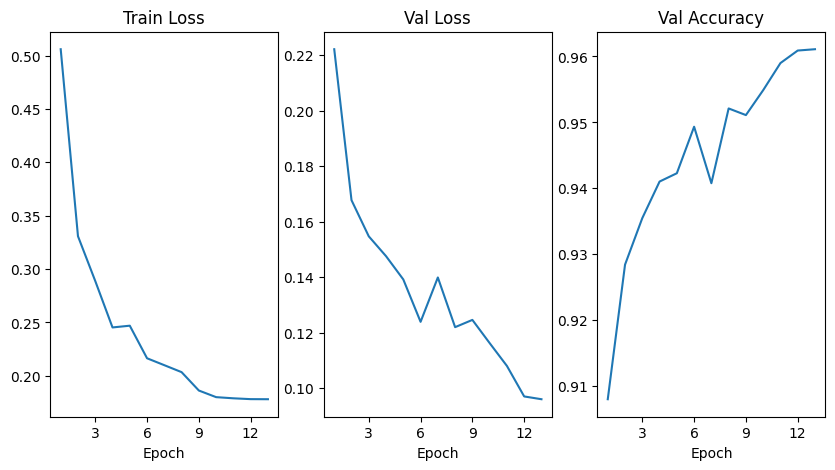

In [68]:
visualize_results(*history)

Correct predictions:


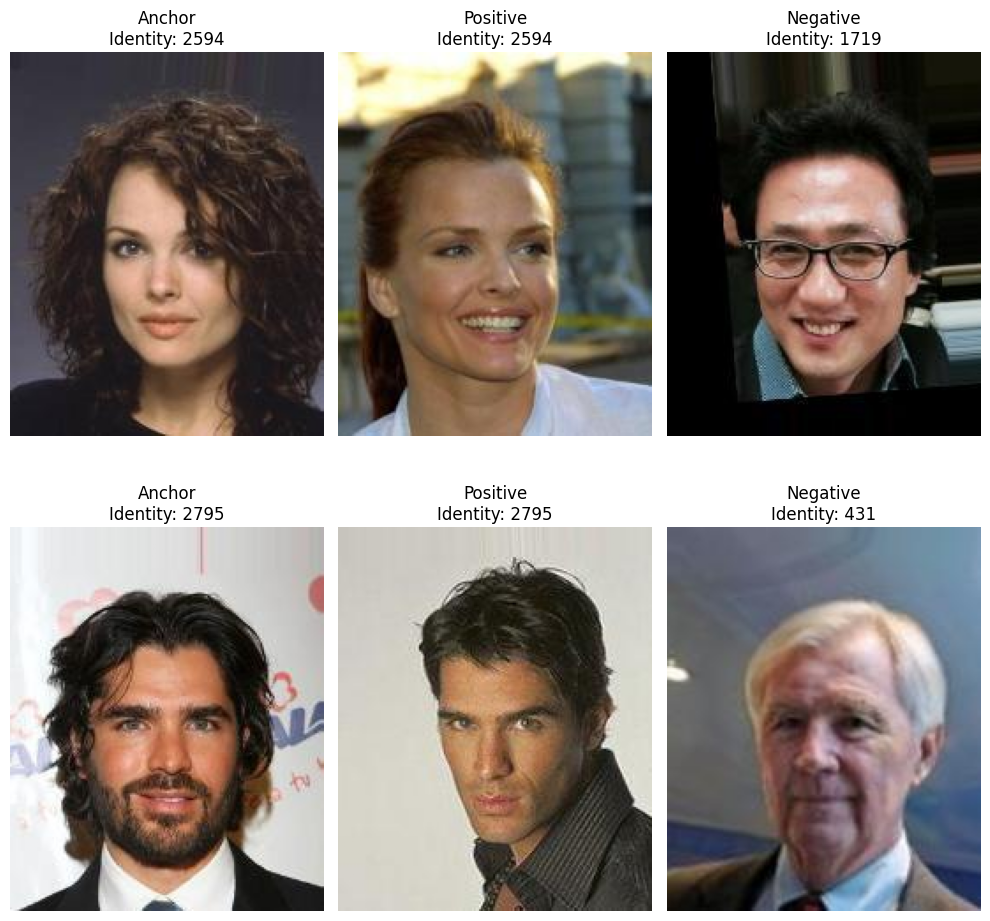

Incorrect predictions:


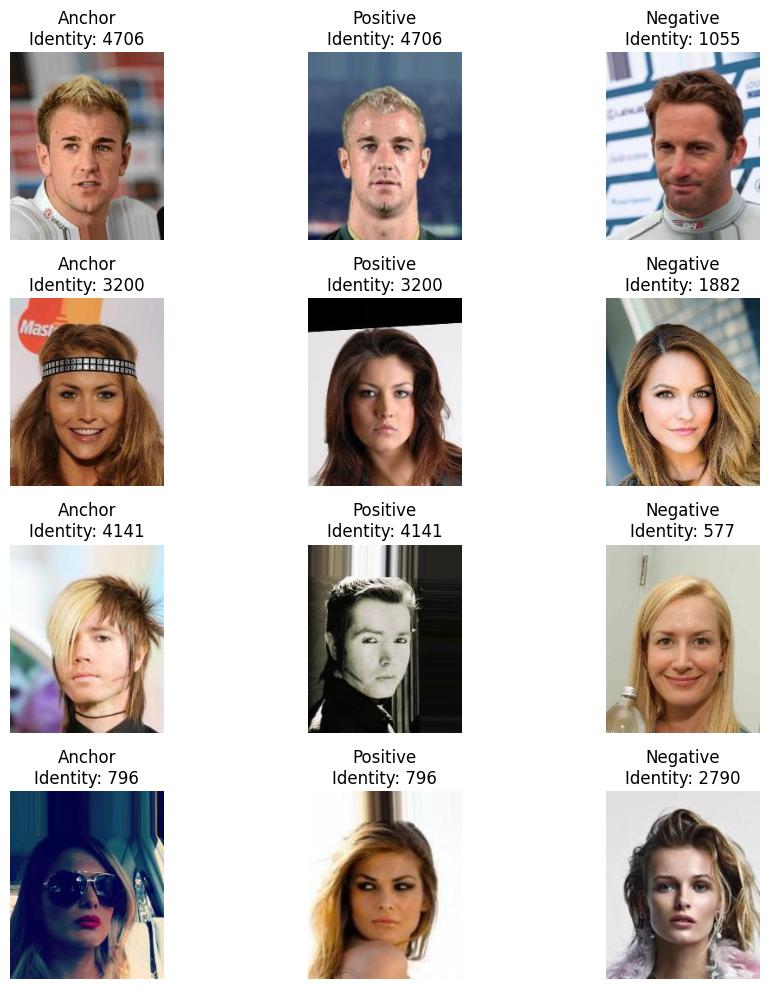

In [15]:
show_predictions(triplet_net, dataloaders[valid_label], num_correct=2, num_incorrect=4)

In [16]:
# HALT RUN ALL - Execute code cells manually from here.
raise Exception("HALTING")

Exception: HALTING

### Save and load model and result history

In [42]:
checkpoint = {
    "model": triplet_net.state_dict(),
    "optimizer": optimizer.state_dict(),
    "lr_scheduler": lr_scheduler.state_dict(),
    "history": history,
}
dest = "models/triplet_net_961.pt" # Annotate with accuracy
torch.save(checkpoint, dest) 

In [22]:
dest = "triplet_net_961.pt"
checkpoint = torch.load(dest)
triplet_net.load_state_dict(checkpoint["model"])
optimizer.load_state_dict(checkpoint["optimizer"])
lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])
history = checkpoint["history"]

### Learning Rate Finder


Finding best learning rate for Adam
  Val loss for lr 5e-05: 0.721                                                                      
  Val loss for lr 0.0001: 0.652                                                                     
  Val loss for lr 0.0005: 0.551                                                                     
  Val loss for lr 0.001: 0.545                                                                      
  Val loss for lr 0.005: 0.826                                                                      
  Val loss for lr 0.01: 0.886                                                                       

Finding best learning rate for Adagrad
  Val loss for lr 5e-05: 0.739                                                                      
  Val loss for lr 0.0001: 0.717                                                                     
  Val loss for lr 0.0005: 0.59                                                                      
  Val loss for

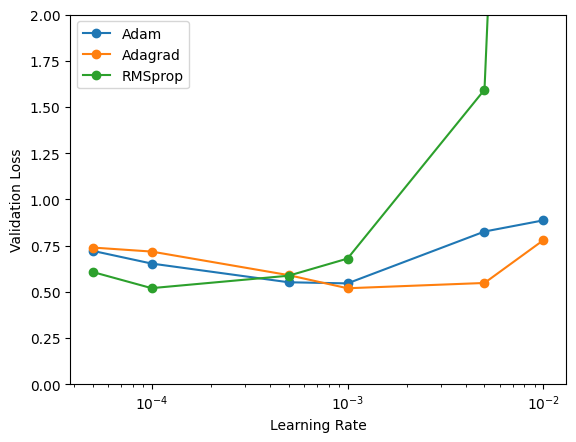

In [22]:
def hyperparameter_finder(state_dict, num_batches, num_val_batches, lr_list, optimizer_class):
    print(f"\nFinding best learning rate for {optimizer_class.__name__}")
    triplet_net_model = TripletNet()
    triplet_net_model.load_state_dict(state_dict)
    triplet_net_model.cuda()
    val_loss_history = []
    for lr in lr_list:
        optimizer = optimizer_class(triplet_net_model.parameters(), lr=lr) # Reset optimizer
        lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=1) # Constant lr
        _, new_history = train_triplet_net(triplet_net_model,
                                        criterion,
                                        optimizer,
                                        lr_scheduler,
                                        freeze=True, # TODO
                                        epochs=1,
                                        num_batches=num_batches,
                                        num_val_batches=num_val_batches,
                                        verbose=False)
        val_loss_history.append(new_history[1][-1])
        print(f"  Val loss for lr {lr}: {round(new_history[1][-1], 3)}")
    return val_loss_history

triplet_state_dict = TripletNet().state_dict()
learning_rates = [0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01]
hp_optimizers = [optim.Adam, optim.Adagrad, optim.RMSprop]
for hp_optim in hp_optimizers:
    result = hyperparameter_finder(triplet_state_dict, 5, 20, learning_rates, hp_optim)
    plt.plot(learning_rates, result, label=hp_optim.__name__, marker="o")

plt.xscale("log")
plt.ylim(0, 2)
plt.xlabel("Learning Rate")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

### Evaluation experiment

In [48]:


def kway_lshot_predictions(num_positives, num_negatives, num_runs, method, plot_first=True):
    assert method in ["mean", "closest"], "Invalid method"
    correct_predictions = 0
    ids = cleaned_identities_splits[valid_label]
    triplet_net.eval()
    
    for i in range(num_runs):
        while True:
            # Get random identity as anchor
            anchor_id = np.random.choice(np.unique(ids)[1:])
            # Get random image from that identity
            anchor_idx = np.random.choice(np.where(ids == anchor_id)[0])
            if anchor_id == 0: continue
            # Get all indexes with the same identity
            anchor_image_indices = np.where(ids == anchor_id)[0]
            # remove the anchor image from the list
            positive_identity_indices = anchor_image_indices[anchor_image_indices != anchor_idx]
            if len(positive_identity_indices) >= num_positives: break
        
        # Get num_positives random positive image
        positive_idxs = positive_identity_indices[np.random.choice(len(positive_identity_indices), num_positives, replace=False)]
        # Choose num_negatives random indexes as negatives and confirm that the ids differ from anchor, positive and 0
        temp_ids = np.unique(ids)[1:] # remove 0
        temp_ids = temp_ids[temp_ids != anchor_id]
        negative_ids = np.random.choice(temp_ids, num_negatives, replace=False)
        
        # Get negative indexes
        negative_idxs = []
        for n_id in negative_ids:
            negative_idxs.append(np.random.choice(np.where(ids == n_id)[0]))

        # Get images
        anchor_img, _ = datasets[valid_label][anchor_idx]
        positive_imgs = [ datasets[valid_label][idx][0] for idx in positive_idxs ]
        negative_imgs = [ datasets[valid_label][idx][0] for idx in negative_idxs ]
        
        # Get embeddings
        with torch.no_grad():
            anchor_emb, positive_embs, negative_embs = triplet_net(torch.stack([anchor_img]).cuda(),
                                                                   torch.stack(positive_imgs).cuda(),
                                                                   torch.stack(negative_imgs).cuda())
            anchor_emb, positive_embs, negative_embs = anchor_emb.cpu().squeeze(), positive_embs.cpu().squeeze(), negative_embs.cpu().squeeze()


        # If num_positives or num_negatives is 1 add extra dimension
        if num_positives == 1: positive_embs = positive_embs.unsqueeze(0)
        if num_negatives == 1: negative_embs = negative_embs.unsqueeze(0)

        # print(anchor_id, negative_ids)
        # print(anchor_idx, positive_idxs, negative_idxs)
        # print(anchor_img.shape, positive_imgs[0].shape, negative_imgs[0].shape)
        # print(anchor_emb.shape, positive_embs.shape, negative_embs.shape)

        # Calculate distances
        made_correct_pred = True
        pred_id = None
        pred_idx = None
        if method == "mean":
            # mean_p = torch.mean(positive_embs, dim=0)
            # use median instead
            mean_p = torch.median(positive_embs, dim=0)[0]
            mean_p_dist = np.linalg.norm(mean_p - anchor_emb)
            for j in range(len(negative_embs)):
                if mean_p_dist > np.linalg.norm(negative_embs[j] - anchor_emb):
                    made_correct_pred = False
                    pred_id = negative_ids[j]
                    pred_idx = j
                    break
            if made_correct_pred:
                correct_predictions += 1
                pred_idx = None
        
        elif method == "closest":
            a_p_dists = [np.linalg.norm(p - anchor_emb) for p in positive_embs]
            a_n_dists = [np.linalg.norm(n - anchor_emb) for n in negative_embs]
            if min(a_p_dists) < min(a_n_dists):
                made_correct_pred = True
                pred_idx = np.argmin(a_p_dists)
                correct_predictions += 1
            else:
                made_correct_pred = False
                pred_id = negative_ids[np.argmin(a_n_dists)]
                pred_idx = np.argmin(a_n_dists)
        
        # print(f"Shot {i+1}: {correct_predictions} correct predictions", end='\n')
        if plot_first and i == 0:
            print("Showing first example\n")
            # plot anchor
            plt.imshow(anchor_img.permute(1, 2, 0))
            plt.title(f"Anchor\nIdentity: {anchor_id}")
            plt.axis('off')
            plt.show()
            # plot positives
            fig, ax = plt.subplots(1, num_positives, figsize=(10+num_positives, num_positives))
            if len(positive_embs) == 1: ax = [ax]
            for j in range(len(positive_embs)):
                titel_color = "black"
                if made_correct_pred and j == pred_idx: titel_color = "green"
                ax[j].imshow(positive_imgs[j].permute(1, 2, 0))
                ax[j].set_title(f"Positive {j+1}", color=titel_color)
                ax[j].axis('off')
            plt.show()
            # plot negatives
            fig, ax = plt.subplots(1, num_negatives, figsize=(10+num_negatives, num_negatives))
            if len(negative_embs) == 1: ax = [ax]
            for j in range(len(negative_embs)):
                titel_color = "black"
                if not made_correct_pred and j == pred_idx: titel_color = "red"
                ax[j].imshow(negative_imgs[j].permute(1, 2, 0))
                ax[j].set_title(f"Negative {j+1}\nIdentity: {negative_ids[j]}", color=titel_color)
                ax[j].axis('off')
            plt.show()
        
        # print(f"{i+1}: {'C' if made_correct_pred else 'Inc'}orrect prediction for identity: {anchor_id}{f', guessed {pred_id}' if pred_id is not None else ''}")

    # print(f"\nCorrect predictions: {correct_predictions}/{num_runs} ({round(correct_predictions/num_runs*100, 2)}%)")   
    return correct_predictions / num_runs



kway_lshot_predictions(4, 100, 100, "closest", plot_first=True)
kway_lshot_predictions(4, 100, 100, "mean", plot_first=True)

In [50]:
all_n = [1, 3, 5, 10]
all_k = [1, 10, 100]
strategies = ["mean", "closest"]
results = np.zeros((len(all_n), len(all_k), len(strategies)))

for strategy in strategies:
    for n in all_n:
        for k in all_k:
            accuracy = kway_lshot_predictions(n, k, 1000, strategy, plot_first=False)
            results[all_n.index(n), all_k.index(k), strategies.index(strategy)] = accuracy
            print(f"Strategy: {strategy}, n: {n}, k: {k}, accuracy: {accuracy}")

Strategy: mean, n: 1, k: 1, accuracy: 0.972
Strategy: mean, n: 1, k: 10, accuracy: 0.795
Strategy: mean, n: 1, k: 100, accuracy: 0.439
Strategy: mean, n: 3, k: 1, accuracy: 0.982
Strategy: mean, n: 3, k: 10, accuracy: 0.901
Strategy: mean, n: 3, k: 100, accuracy: 0.675
Strategy: mean, n: 5, k: 1, accuracy: 0.986
Strategy: mean, n: 5, k: 10, accuracy: 0.931
Strategy: mean, n: 5, k: 100, accuracy: 0.721
Strategy: mean, n: 10, k: 1, accuracy: 0.99
Strategy: mean, n: 10, k: 10, accuracy: 0.95
Strategy: mean, n: 10, k: 100, accuracy: 0.775
Strategy: closest, n: 1, k: 1, accuracy: 0.963
Strategy: closest, n: 1, k: 10, accuracy: 0.777
Strategy: closest, n: 1, k: 100, accuracy: 0.439
Strategy: closest, n: 3, k: 1, accuracy: 0.984
Strategy: closest, n: 3, k: 10, accuracy: 0.93
Strategy: closest, n: 3, k: 100, accuracy: 0.675
Strategy: closest, n: 5, k: 1, accuracy: 0.995
Strategy: closest, n: 5, k: 10, accuracy: 0.955
Strategy: closest, n: 5, k: 100, accuracy: 0.77
Strategy: closest, n: 10, k: 

### TSNE

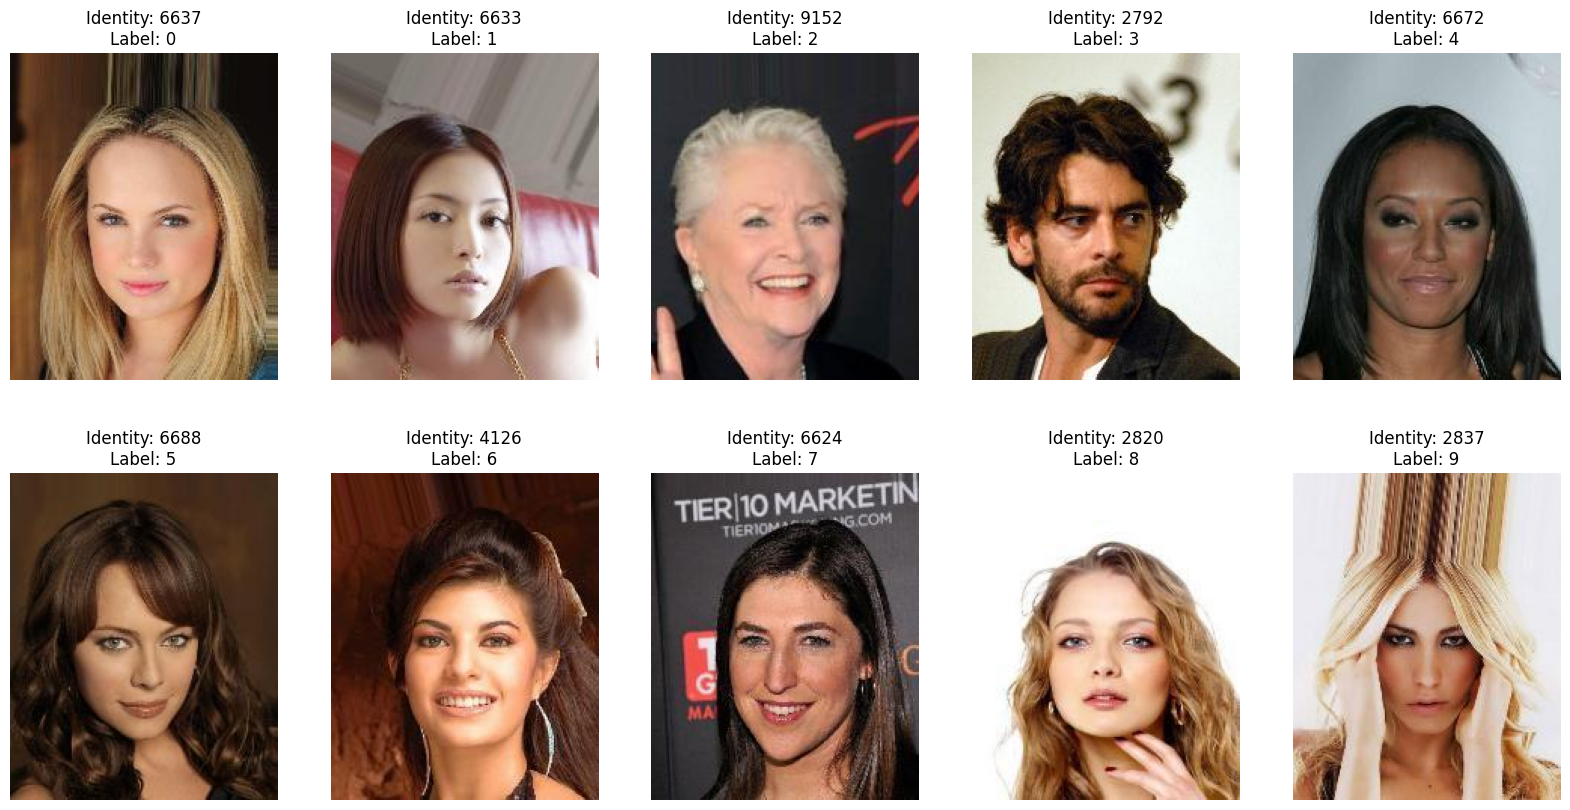

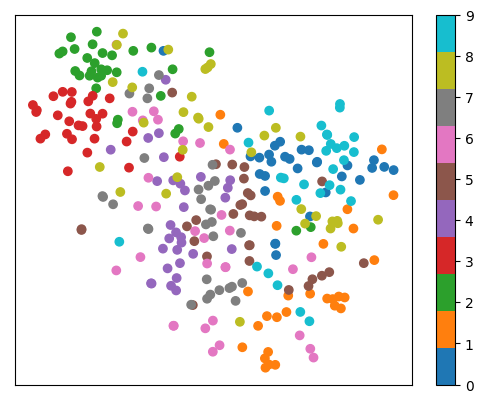

In [60]:

def get_top_n_ids(n):
    # Get identities with the n most amount of images
    ids = cleaned_identities_splits[train_label]
    identity_counts = np.bincount(ids)
    identity_counts[0] = 0  # Ignore invalid identities
    top10_identities = np.argsort(identity_counts)[-n:]
    return top10_identities


def plot_TSNE(all_ids, ids_to_TSNE, show_imgs, use_net=True):
    num_ids_to_show = len(ids_to_TSNE)
    # Get all images with the top 10 identities
    top10_idx_lists = [np.where(all_ids == id)[0] for id in ids_to_TSNE]
    top10_labels = np.concatenate([[i]*len(idx) for i,idx in enumerate(top10_idx_lists)])
    top10_idx = np.concatenate(top10_idx_lists)

    # Get activations for all images with the top 10 identities
    top10_activations = []
    triplet_net.eval()
    with torch.no_grad():
        # Run model on all images with the top 10 identities
        for i in range(0, len(top10_idx), bs):
            batch = top10_idx[i:i + bs]
            imgs = torch.stack([datasets[train_label][idx][0] for idx in batch])
            if use_net:
                # activations, _, _ = triplet_net(imgs.cuda(), imgs.cuda(), imgs.cuda())
                activations = torch.Tensor(triplet_net.resnet(imgs.cuda()))
            else:
                activations = imgs.view(imgs.shape[0], -1)
            activations = activations.cpu().numpy()
            top10_activations.extend(activations)

    top10_activations = np.array(top10_activations)

    if show_imgs:
        # Plot one image per identity
        columns = 5
        fig, ax = plt.subplots(math.ceil(num_ids_to_show/columns), columns, figsize=(20, 10))
        if ax.ndim == 1: ax = np.array([ax])
        for i in range(num_ids_to_show):
            rnd_idx = np.random.randint(0, len(top10_idx_lists[i]))
            img = datasets[train_label][top10_idx_lists[i][rnd_idx]][0]
            ax[i//columns, i%columns].imshow(img.permute(1, 2, 0))
            ax[i//columns, i%columns].set_title(f"Identity: {ids_to_TSNE[i]}\nLabel: {i}")
            ax[i//columns, i%columns].axis('off')
        for i in range(num_ids_to_show, ax.size): ax[i//columns, i%columns].axis('off')
        # plt.tight_layout()
        plt.show()

    # Plot TSNE of activations
    tsne = TSNE(n_components=2, init='pca', learning_rate='auto')
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tsne_activations = tsne.fit_transform(top10_activations)
    if num_ids_to_show <= 10: cmap = "tab10"
    elif num_ids_to_show <= 20: cmap = "tab20"
    else: cmap = "gist_ncar"
    plt.scatter(tsne_activations[:, 0], tsne_activations[:, 1], c=top10_labels, cmap=plt.get_cmap(cmap))
    plt.colorbar()
    # no axis ticks
    plt.xticks([])
    plt.yticks([])
    plt.show()


# use_identities = np.random.choice(get_top_n_ids(30), 10, replace=False)
# print(use_identites)
use_identities = [6637, 6633, 9152, 2792, 6672, 6688, 4126, 6624, 2820, 2837]
plot_TSNE(cleaned_identities_splits[train_label], use_identities, show_imgs=True, use_net=True)

### Confidence Experiment

In [37]:
def val_triplet_net(batches=None):
    valid_dl = dataloaders[valid_label]
    samples_done = 0
    dist_diffs = []
    triplet_net.eval()
    with torch.no_grad():
        for i, triplet_batch in enumerate(valid_dl):
            if i == batches: break
            anchor, positive, negative = triplet_batch[0]
            anchor, positive, negative = triplet_net(anchor.cuda(), positive.cuda(), negative.cuda())
            anchor, positive, negative = anchor.cpu(), positive.cpu(), negative.cpu()
            samples_done += len(anchor)
            for j in range(len(anchor)):
                anchor_pos_dist = np.linalg.norm(anchor[j] - positive[j])
                anchor_neg_dist = np.linalg.norm(anchor[j] - negative[j])
                dist_diffs.append(anchor_neg_dist - anchor_pos_dist)
    return dist_diffs


dist_diffs = val_triplet_net(batches=None)
dist_diffs = np.array(dist_diffs)

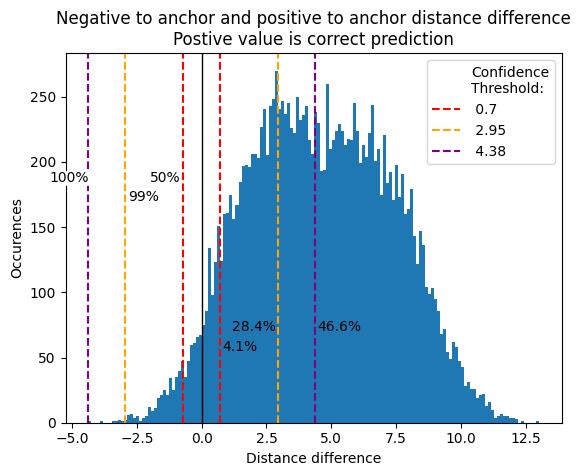

In [38]:
from matplotlib.lines import Line2D

plt.hist(dist_diffs, bins=150)
plt.axvline(x=0, color='black', linewidth=1)

# Show 50th, 1st, 0.1st percentiles of only negative values
incor_dist_diffs = dist_diffs[dist_diffs < 0]
percentile50_incor = np.percentile(incor_dist_diffs, 50)
percentile1_incor = np.percentile(incor_dist_diffs, 1)
percentile0_incor = np.percentile(incor_dist_diffs, 0)

plt.axvline(x=percentile50_incor, color='red', linestyle='dashed')
plt.axvline(x=percentile1_incor, color='orange', linestyle='dashed')
plt.axvline(x=percentile0_incor, color='purple', linestyle='dashed')

plt.text(percentile50_incor-0.1, 185, "50%", ha='right')
plt.text(percentile1_incor+0.1, 170, "99%")
plt.text(percentile0_incor+0.04, 185, "100%", ha='right', bbox=dict(facecolor='white', pad=0, linewidth=0.5, edgecolor='white'))

# Show the same for only positive values
plt.axvline(x=-percentile50_incor, color='red', linestyle='dashed')
plt.axvline(x=-percentile1_incor, color='orange', linestyle='dashed')
plt.axvline(x=-percentile0_incor, color='purple', linestyle='dashed')

# Count how many of positive values are > than the percentiles above
corr_dist_diffs = dist_diffs[dist_diffs > 0]
corr_perc_50th = corr_dist_diffs[corr_dist_diffs < -percentile50_incor].shape[0] / corr_dist_diffs.shape[0] * 100
corr_perc_1st = corr_dist_diffs[corr_dist_diffs < -percentile1_incor].shape[0] / corr_dist_diffs.shape[0] * 100
corr_perc_0th = corr_dist_diffs[corr_dist_diffs < -percentile0_incor].shape[0] / corr_dist_diffs.shape[0] * 100

plt.text(-percentile50_incor+0.1, 55, f"{round(corr_perc_50th, 1)}%", ha='left')
plt.text(-percentile1_incor-0.1, 70, f"{round(corr_perc_1st, 1)}%", ha='right')
plt.text(-percentile0_incor+0.1, 70, f"{round(corr_perc_0th, 1)}%", ha='left')

# plt.legend(["None", "50th", "1st", "0th"])

plt.legend([
               Line2D([0], [4], color='white', linewidth=1),
               Line2D([0], [0], color='red', linestyle='dashed'),
               Line2D([0], [0], color='orange', linestyle='dashed'),
               Line2D([0], [0], color='purple', linestyle='dashed')
            ],
           [
               "Confidence\nThreshold:",
               f" {round(-percentile50_incor ,2)}",
               f" {round(-percentile1_incor ,2)}",
               f" {round(-percentile0_incor ,2)}"
            ])

plt.xlabel("Distance difference")
plt.ylabel("Occurences")
plt.title("Negative to anchor and positive to anchor distance difference\nPostive value is correct prediction")
plt.show()

### Grad-CAM Test

In [ ]:
triplet_net.resnet.layer4[1].conv2.weight.shape, triplet_net.resnet.layer4[1].conv2

In [ ]:
# defines two global scope variables to store our gradients and activations
gradients = None
activations = None


def backward_hook(module, grad_input, grad_output):
    global gradients  # refers to the variable in the global scope
    print('Backward hook running...')
    gradients = grad_output
    # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
    print(f'Gradients size: {gradients[0].size()}')
    # We need the 0 index because the tensor containing the gradients comes
    # inside a one element tuple.


def forward_hook(module, args, output):
    global activations  # refers to the variable in the global scope
    print('Forward hook running...')
    activations = output
    # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
    print(f'Activations size: {activations.size()}')


# We register our hooks to the conv2 layer
triplet_net.resnet.layer4[1].conv2.register_full_backward_hook(backward_hook)
triplet_net.resnet.layer4[1].conv2.register_full_forward_hook(forward_hook)

# We run the model on a batch of images
triplet_net.eval()
with torch.no_grad():
    anchor, positive, negative = next(iter(dataloaders[train_label]))[0]
    anchor, positive, negative = anchor.cuda(), positive.cuda(), negative.cuda()
    anchor, positive, negative = triplet_net(anchor, positive, negative)


In [ ]:

# plot activation of last conv layer of resnet
img = datasets[train_label][0][0].unsqueeze(0)
layer = triplet_net.resnet.layer4[1].conv2
triplet_net.eval()
with torch.no_grad():
    _, _, activations = triplet_net(img.cuda(), img.cuda(), img.cuda())
    activations = activations.cpu().numpy()
    activations = np.mean(activations, axis=1).squeeze()
    plt.imshow(activations)
    plt.show()

